In [1]:
42

42

# Creating Datasets in PyTorch

PyTorch provides the `Dataset` and `DataLoader` classes to handle data efficiently.

In [2]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self):
        # Initialization code
        pass

    def __len__(self):
        # Returns the total number of samples
        return 0

    def __getitem__(self, idx):
        # Generates one sample of data
        return None


In [3]:
myData = CustomDataset()
myData

In [4]:
len(myData)

0

In [5]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self):
        # Initialization code
        pass

    def __len__(self):
        # Returns the total number of samples
        return 10

    def __getitem__(self, idx):
        # Generates one sample of data
        return idx

myData = CustomDataset()
print(len(myData))
for i in range(len(myData)):
    print(i)

10
0
1
2
3
4
5
6
7
8
9


In [6]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self):
        # Initialization code
        pass

    def __len__(self):
        # Returns the total number of samples
        return 10

    def __getitem__(self, idx):
        # Generates one sample of data
        if idx < len(self):
            return idx
        else:
            raise IndexError("Index out of range")

    def __iter__(self):
        # This makes the dataset iterable
        for i in range(len(self)):
            yield self[i]

myData = CustomDataset()
print(len(myData))
for i in myData:
    print(i)


10
0
1
2
3
4
5
6
7
8
9


# Image Datasets

### Dataset Used: CIFAR-10

Files already downloaded and verified


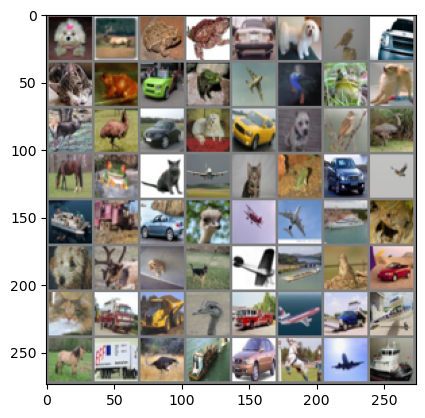

  dog  deer  frog  frog automobile   dog  bird automobile


In [8]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Function to unnormalize and convert tensor to image for visualization
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()  # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # rearrange dimensions to (H, W, C)
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # use next(dataiter) instead of dataiter.next()

# Show images
imshow(utils.make_grid(images))

# Print labels
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(8)))  # print first 8 labels


# Text Datasets

**Dataset Used**: IMDb Reviews

In [2]:
%pip install portalocker

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'i:\Installs\python.exe -m pip install --upgrade pip' command.


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, file_path, max_length=10):
        # Load the file and split it into lines
        with open(file_path, 'r') as f:
            self.lines = f.readlines()
        
        # Tokenizer
        self.tokenizer = get_tokenizer('basic_english')
        
        # Maximum length of tokens (fixed length)
        self.max_length = max_length

    def __len__(self):
        # Returns the total number of lines in the file
        return len(self.lines)

    def __getitem__(self, idx):
        # Tokenize the line at the given index
        text = self.lines[idx].strip()  # Remove any trailing newlines or spaces
        tokens = self.tokenizer(text)
        
        # Convert tokens to a tensor and pad/truncate them to max_length
        token_ids = torch.tensor([ord(token[0]) for token in tokens], dtype=torch.long)  # Simple token encoding for example
        
        # Pad or truncate the token_ids to the fixed max_length
        if len(token_ids) < self.max_length:
            token_ids = torch.cat([token_ids, torch.zeros(self.max_length - len(token_ids), dtype=torch.long)])
        else:
            token_ids = token_ids[:self.max_length]
        
        # Return tokenized text and a dummy label (e.g., 0)
        label = 0  # Assign dummy label (for example purposes)
        return token_ids, label

# File path to sample.txt
file_path = 'sample.txt'  # Make sure 'sample.txt' exists in the working directory

# Create Dataset instance with a fixed maximum sequence length (for padding)
train_dataset = TextDataset(file_path, max_length=10)

# Create DataLoader instance (no need for collate_fn)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Example usage of train_loader
for batch_idx, (token_ids, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Token IDs: {token_ids}")
    print(f"Labels: {labels}")
    print("-------")


Batch 1
Token IDs: tensor([[116, 105, 116, 102, 108,  46,   0,   0,   0,   0],
        [ 97, 108, 111, 116, 104,  46,   0,   0,   0,   0]])
Labels: tensor([0, 0])
-------
Batch 2
Token IDs: tensor([[121,  97, 115, 115,  46,   0,   0,   0,   0,   0],
        [102, 108, 105, 116, 102,  46,   0,   0,   0,   0]])
Labels: tensor([0, 0])
-------


PyTorch's dataloader required tensors in a batch to have the same shape
To fix this we need to "Handle Variable Length Sequences" and write a custom "Collate Function". We have written our code to be much simpler above

In [1]:
%pip install soundfile
import torchaudio
torchaudio.set_audio_backend("soundfile")

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'i:\Installs\python.exe -m pip install --upgrade pip' command.


i:\Installs\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


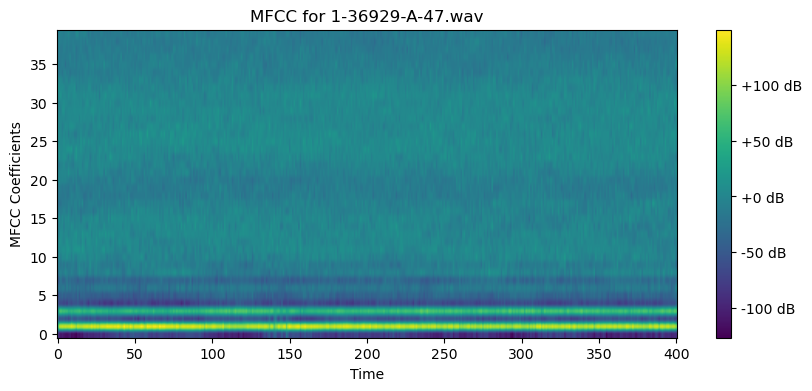

Audio data (original signal): [-0.20997207 -0.27414626 -0.17315517 ... -0.03094712 -0.03553449
 -0.04003534]
Label: ('airplane',)


In [10]:
import os
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ESC50Dataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate):
        # Load the CSV file with annotations (meta/esc50.csv)
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get the file path and label from the CSV
        audio_sample_path = os.path.join(self.audio_dir, self.annotations.iloc[idx]['filename'])
        label = self.annotations.iloc[idx]['category']
        signal, sr = torchaudio.load(audio_sample_path)

        # Resample if necessary
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            signal = resampler(signal)

        # Store the original signal before transformation for playback
        original_signal = signal.clone()

        # Apply transformations (e.g., MFCC)
        signal = self.transformation(signal)
        return signal, label, audio_sample_path, sr, original_signal, sr  # Include original signal for visualization

# Define transformations
transformation = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=40)

# Create Dataset and DataLoader
audio_dataset = ESC50Dataset(
    annotations_file='ESC-50-master/meta/esc50.csv',  # Path to the ESC-50 CSV file
    audio_dir='ESC-50-master/audio',  # Path to the folder with audio files
    transformation=transformation,
    target_sample_rate=16000
)
audio_loader = DataLoader(audio_dataset, batch_size=1, shuffle=True)

# Function to plot and display the audio widget (no playback)
def visualize_audio(signal, sr, audio_sample_path, original_signal, original_sr):
    # MFCC output will be 3D: [channels, features (MFCC coefficients), time_steps]
    # Take the first channel (mono) and transpose it to plot (time on x-axis)
    signal_mfcc = signal[0].numpy()  # Take the first channel
    
    # Plot the MFCC (features on y-axis, time steps on x-axis)
    plt.figure(figsize=(10, 4))
    plt.imshow(signal_mfcc, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"MFCC for {os.path.basename(audio_sample_path)}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.show()

    # Display the audio as an array (do not attempt to play it)
    print(f"Audio data (original signal): {original_signal.numpy().squeeze()}")

# Iterate through the dataset
for signal, label, audio_sample_path, sr, original_signal, original_sr in audio_loader:
    # Visualize the first audio sample in the batch
    visualize_audio(signal[0], sr, audio_sample_path[0], original_signal[0], original_sr)
    print(f"Label: {label}")
    break  # Visualize only the first sample for now


# 3D Datasets

Dataset Used: Sample_cube.off

In [1]:
%pip install trimesh

     -------------------------------------- 703.7/703.7 KB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'i:\Installs\python.exe -m pip install --upgrade pip' command.


i:\Installs\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


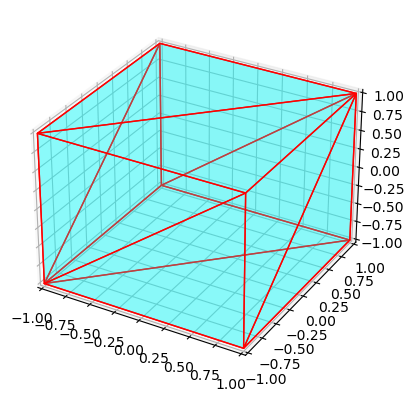

Label: cube


In [2]:
import torch
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from torch.utils.data import Dataset, DataLoader
import os

class SingleSampleDataset(Dataset):
    def __init__(self, sample_file):
        self.sample_file = sample_file

    def __len__(self):
        return 1  # Only one sample

    def __getitem__(self, idx):
        # Load the mesh using trimesh
        mesh = trimesh.load(self.sample_file)
        vertices = torch.tensor(mesh.vertices, dtype=torch.float)
        faces = torch.tensor(mesh.faces, dtype=torch.long)
        label = "cube"  # Set a dummy label for this example
        return {'vertices': vertices, 'faces': faces, 'label': label}

# Function to visualize the mesh
def visualize_mesh(vertices, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a Poly3DCollection object for the faces
    poly3d = [[vertices[face[0]], vertices[face[1]], vertices[face[2]]] for face in faces]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

    # Set plot limits
    ax.set_xlim([vertices[:, 0].min(), vertices[:, 0].max()])
    ax.set_ylim([vertices[:, 1].min(), vertices[:, 1].max()])
    ax.set_zlim([vertices[:, 2].min(), vertices[:, 2].max()])

    plt.show()

# Load the dataset and dataloader
sample_dataset = SingleSampleDataset(sample_file='sample_cube.off')  # Adjust path accordingly
sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

# Iterate through the dataloader and visualize the 3D sample
for data in sample_loader:
    vertices = data['vertices'][0].numpy()  # Convert from tensor to numpy for plotting
    faces = data['faces'][0].numpy()  # Convert from tensor to numpy for plotting
    visualize_mesh(vertices, faces)
    print(f"Label: {data['label'][0]}")


# Data Preprocessing Techniques

**Images**

- Resizing: To ensure all images are the same size.
- Normalization: Scaling pixel values to a standard range.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Text

- Tokenization: Splitting text into tokens.
- Padding/Truncating: To ensure sequences are of equal length.
- Embedding: Mapping tokens to vectors.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = [torch.tensor(text) for text in texts]
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.tensor(labels)
    return texts_padded, labels


# Audio

-Resampling: To standardize sampling rates.
-Feature Extraction: Converting raw audio to features like MFCCs.

In [ ]:
transformation = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=40)


# 3D Data

- Normalization: Scaling to a unit sphere.
- Centering: Shifting to the origin.

In [ ]:
def normalize(vertices):
    centroid = vertices.mean(dim=0)
    vertices = vertices - centroid
    max_dist = torch.max(torch.norm(vertices, dim=1))
    vertices = vertices / max_dist
    return vertices


# Data Augmentation

## Images

**Techniques**:
- Random Horizontal Flip
- Random Rotation
- Color Jitter

In [ ]:
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


# Text

**Techniques**:
- Synonym Replacement
- Random Insertion
- Back-Translation

In [ ]:
import random
from nltk.corpus import wordnet

def synonym_replacement(sentence, n):
    words = sentence.split()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            words = [synonym if word == word_to_replace else word for word in words]
    return ' '.join(words)


# Audio

**Techniques**:
- Time Stretching
- Pitch Shifting
- Adding Background Noise

In [ ]:
def add_background_noise(signal, noise_factor=0.005):
    noise = torch.randn_like(signal)
    augmented_signal = signal + noise_factor * noise
    return augmented_signal


# 3D Data

**Techniques**:
- Random Rotation
- Scaling
- Adding Noise

In [ ]:
def random_rotation(vertices):
    theta = random.uniform(0, 2 * math.pi)
    rotation_matrix = torch.tensor([
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta),  math.cos(theta), 0],
        [0, 0, 1]
    ])
    return vertices @ rotation_matrix


# Building Deep Learning Models

# CNNs for Images
Model Architecture:

In [ ]:
import torch.nn as nn

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Add more layers as needed
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 62 * 62, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # For CIFAR-10
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


**Training Loop**

In [ ]:
model = ImageClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# Transformers for Text
Model Architecture:

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


**Training Loop**

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    for texts, labels in train_loader:
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# CNNs/RNNs for Audio
Model Architecture:

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            # Add more layers as needed
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * computed_feature_size, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


# PointNet for 3D Data
Model Architecture:

In [ ]:
class PointNetClassifier(nn.Module):
    def __init__(self, k=2):
        super(PointNetClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # Add more layers as needed
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, k)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.max(x, 2)[0]  # Global max pooling
        x = self.fc_layers(x)
        return x
